# Ghost (Single-Pixel) Imaging
![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fsrep09280/MediaObjects/41598_2015_Article_BFsrep09280_Fig1_HTML.jpg?as=webp)

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

test = Image.open('../assets/USAF.png').convert('L') #load test image

test = test.resize((128, 128)) # resize image to desire size
test = np.array(test).reshape(-1) # reshape to 1-d array
test = (test - np.min(test)) / (np.max(test) - np.min(test)) # minmax normalization

image_len = test.shape[0]
sample_ratio = 1.0 # assign sample ratio
sample_times = round(sample_ratio * image_len) # assign sample times

Ghost imaging (Single pixel imaging) can be regarded as:
$$
\mathbf{Ax}=\mathbf{b}
$$
where $A ∈ R_{m×n}$ denotes the light modulation matrix (m modulation patterns, and each pattern consists of n pixels), $\mathbf{x} ∈ R_{n×1}$ stands for the target scene (aligned as a vector) to be reconstructed, and $b ∈ R_{m×1}$ is the measurement vector. 

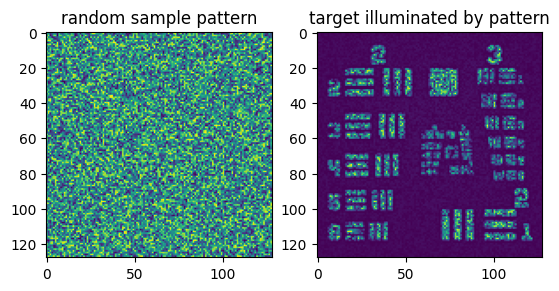

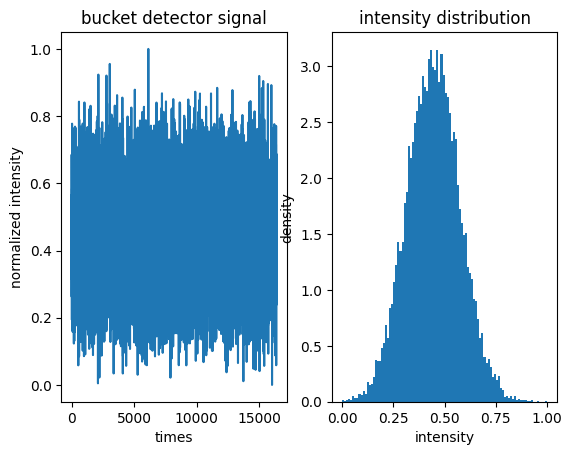

In [2]:
m= sample_times
n= image_len
x=test
A = np.random.rand(m, n) # generate random sample pattern
b = A @ x
b = (b - np.min(b)) / (np.max(b) - np.min(b))

plt.subplot(1,2,1)
plt.imshow(A[0,:].reshape(128,128))
plt.title('random sample pattern')
plt.subplot(1,2,2)
plt.imshow(A[0,:].reshape(128,128)*test.reshape(128,128))
plt.title('target illuminated by pattern')
plt.show()

plt.subplot(1,2,1)
plt.plot(b)
plt.title('bucket detector signal')
plt.xlabel('times')
plt.ylabel('normalized intensity')
plt.subplot(1,2,2)
plt.hist(b, bins=100, density=True)
plt.title('intensity distribution')
plt.xlabel('intensity')
plt.ylabel('density')
plt.show()


The original signal $\mathbf{x}$ can be recovered directly by
$$
\mathbf{A}^T\mathbf{A}\mathbf{x}=\mathbf{A}^T\mathbf{b},
$$
and $\mathbf{x}$ can be expressed as:
$$
\mathbf{x}=(\mathbf{A}^T\mathbf{A})^{-1}\mathbf{A}^T\mathbf{b}.
$$
This is essentially equivalent to minimizing $||\mathbf{Ax} − \mathbf{b}||_{l2}$ when $m > n$ . However, $\mathbf{A^{T}A}$ is non-full rank when $m < n$ , and the method would not work. So addition reconstruction algorithm is required for practical application.

There are two simple but widely-used algorithm for reconstruction - "Normalized GI" and "Differential GI"

In [3]:
def fun_SPI_R_NGI(patterns, measurements):

    measurements = np.asarray(measurements)

    num_measurements = patterns.shape[0]
    image_len = int(np.sqrt(patterns.shape[1]))
    

    patterns_reshaped = patterns.reshape(num_measurements, image_len, image_len)
    
    avg_B = np.mean(measurements)
    
    avg_I = np.mean(patterns_reshaped, axis=0)

    correlation_term = np.mean(
        patterns_reshaped * measurements[:, np.newaxis, np.newaxis], 
        axis=0
    )
    epsilon = 1e-9
    denominator = avg_B * avg_I + epsilon
    
    reconstructed_image = correlation_term / denominator

    reconstructed_image = (reconstructed_image-np.min(reconstructed_image))/(np.max(reconstructed_image)-np.min(reconstructed_image))
    
    return reconstructed_image

def fun_SPI_R_DGI(patterns, measurements):

    measurements = np.asarray(measurements)
    
    num_measurements = patterns.shape[0]
    image_len = int(np.sqrt(patterns.shape[1]))

    patterns_reshaped = patterns.reshape(num_measurements, image_len, image_len)
    
    avg_B = np.mean(measurements)
    
    avg_I = np.mean(patterns_reshaped, axis=0)
    

    correlation_term = np.mean(
        patterns_reshaped * measurements[:, np.newaxis, np.newaxis], 
        axis=0
    )

    reconstructed_image = correlation_term - avg_B * avg_I
    
    reconstructed_image = (reconstructed_image-np.min(reconstructed_image))/(np.max(reconstructed_image)-np.min(reconstructed_image))

    return reconstructed_image

Run the cell below to see the reconstruction results when imaging under different sample ratio(5.0/1.0/0.2)

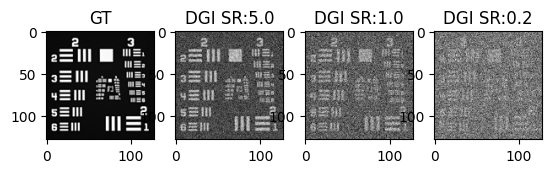

In [4]:
plt.subplot(1,4,1)
plt.imshow(test.reshape(128, 128),cmap='gray')
plt.title('GT')

sample_ratio = 5.0
sample_times = round(sample_ratio * image_len) # assign sample times
m= sample_times
n= image_len
x=test
A = np.random.rand(m, n) # generate random sample pattern
b = A @ x
b = (b - np.min(b)) / (np.max(b) - np.min(b))
img_DGI = fun_SPI_R_DGI(A,b)
plt.subplot(1,4,2)
plt.imshow(img_DGI,cmap='gray')
plt.title('DGI SR:%.1f'%sample_ratio)

sample_ratio = 1.0
sample_times = round(sample_ratio * image_len) # assign sample times
m= sample_times
n= image_len
x=test
A = np.random.rand(m, n) # generate random sample pattern
b = A @ x
b = (b - np.min(b)) / (np.max(b) - np.min(b))
img_DGI = fun_SPI_R_DGI(A,b)
plt.subplot(1,4,3)
plt.imshow(img_DGI,cmap='gray')
plt.title('DGI SR:%.1f'%sample_ratio)


sample_ratio = 0.2
sample_times = round(sample_ratio * image_len) # assign sample times
m= sample_times
n= image_len
x=test
A = np.random.rand(m, n) # generate random sample pattern
b = A @ x
b = (b - np.min(b)) / (np.max(b) - np.min(b))
img_DGI = fun_SPI_R_DGI(A,b)
plt.subplot(1,4,4)
plt.imshow(img_DGI,cmap='gray')
plt.title('DGI SR:%.1f'%sample_ratio)
plt.show()

The reconstruction of Ghost Imaging is a general inverse problem. Data-driven neural network is a good and efficient way to solve the problem. But it does need pre-trained model and lack of generalization among different kinds of natural images.

Next is the model-driven neural network for image reconstruction. The network can retrieval the image by minimize the loss of physical imaging model. Here we present the example with a simple multilayer perceptron.

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm

def fun_SPI_R_GINR(patterns: np.ndarray, measurements: np.ndarray) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    image_len = round(np.sqrt(patterns.shape[1]))
    num_epochs = 3000
    learning_rate = 1e-4

    sample_matrix = torch.from_numpy(patterns).float().to(device)
    bucket_signal = torch.from_numpy(measurements).float().to(device)

    coords = get_mgrid(image_len, 2).float().to(device)
    
    model = Siren(in_features=2, out_features=1, hidden_features=128,
                  hidden_layers=2, outermost_linear=True).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.L1Loss()

    epoch_iterator = tqdm(range(num_epochs), desc="Training GINR Model", leave=True)

    for epoch in epoch_iterator:
        model.train()

        optimizer.zero_grad()

        outputs, _ = model(coords)
        
        outputs_flat = outputs.view(-1)
        
        measurement = sample_matrix @ outputs_flat

        min_meas = torch.min(measurement)
        max_meas = torch.max(measurement)
        if max_meas == min_meas:
            measurement_normalized = torch.zeros_like(measurement)
        else:
            measurement_normalized = (measurement - min_meas) / (max_meas - min_meas)

        loss = criterion(measurement_normalized, bucket_signal)

        loss.backward()
        optimizer.step()

        epoch_iterator.set_postfix(loss=loss.item())

    model.eval()
    with torch.no_grad():
        final_outputs, _ = model(coords)
        final_outputs = final_outputs.view(image_len, image_len).cpu().numpy()
        final_outputs = (final_outputs-np.min(final_outputs))/(np.max(final_outputs)-np.min(final_outputs))
    return final_outputs

def get_mgrid(sidelen, dim=2):
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)

    tensors = tuple([torch.linspace(-1, 1, length) for length in sidelen])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    return mgrid.reshape(-1, dim)

class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                             np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)  # allows to take derivative w.r.t. input

        output = self.net(coords)
        return output, coords

As the figures show below, the GINR method shows better reconstruction quality and higher contrast than the traditional DGI algorithm, especially under low sample ratio condition.

Training GINR Model: 100%|██████████| 3000/3000 [00:22<00:00, 134.83it/s, loss=0.0158]


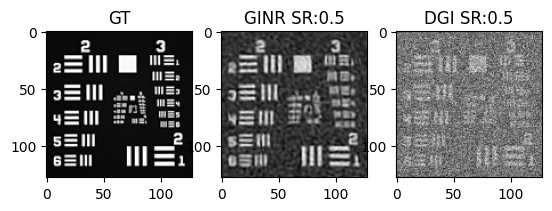

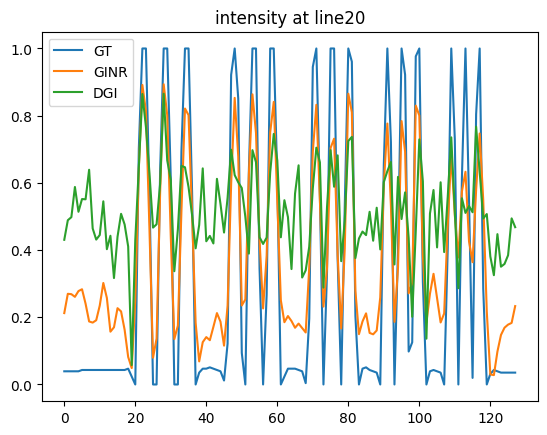

In [ ]:
gt = test.reshape(128, 128).astype(np.float32)
gt = (gt-np.min(gt))/(np.max(gt)-np.min(gt))
plt.subplot(1,3,1)
plt.imshow(test.reshape(128, 128),cmap='gray')
plt.title('GT')

sample_ratio = 0.5
sample_times = round(sample_ratio * image_len) # assign sample times
m= sample_times
n= image_len
x=test
A = np.random.rand(m, n) # generate random sample pattern
b = A @ x
b = (b - np.min(b)) / (np.max(b) - np.min(b))
img_GINR = fun_SPI_R_GINR(A, b)

plt.subplot(1,3,2)
plt.imshow(img_GINR,cmap='gray')
plt.title('GINR SR:%.1f'%sample_ratio)


img_DGI = fun_SPI_R_DGI(A, b)
plt.subplot(1,3,3)
plt.imshow(img_DGI,cmap='gray')
plt.title('DGI SR:%.1f'%sample_ratio)

plt.show()

line_index =  20
plt.plot(gt[:,line_index],label= 'GT')
plt.plot(img_GINR[:,line_index],label = 'GINR')
plt.plot(img_DGI[:,line_index],label = 'DGI')
plt.title('intensity at line%d'%(line_index))
plt.legend()
plt.show()
